In [3]:
import requests
import os
import json
import TwitterSecrets


bearer_token = TwitterSecrets.Bearer_Token

In [4]:
USER_ID = '1009984504247676928'

follower_url = f"https://api.twitter.com/2/users/{USER_ID}/followers"
following_url = f"https://api.twitter.com/2/users/{USER_ID}/following"
user_url = "https://api.twitter.com/2/users"
user_by_url = user_url + '/by'

# Optional params: start_time,end_time,since_id,until_id,max_results,next_token,
# expansions,tweet.fields,media.fields,poll.fields,place.fields,user.fields
query_params = {'query': '#MarchMadness'}

In [5]:
def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2RecentSearchPython"
    return r

def connect_to_endpoint(url, params):
    response = requests.get(url, auth=bearer_oauth, params=params)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

In [6]:
CACHE_FILENAME = "cache.json"

def open_cache():
    ''' opens the cache file if it exists and loads the JSON into
    the CACHE dictionary.

    if the cache file doesn't exist, creates a new cache dictionary

    Parameters
    ----------
    None

    Returns
    -------
    The opened cache
    '''
    try:
        cache_file = open(CACHE_FILENAME, 'r')
        cache_contents = cache_file.read()
        cache_dict = json.loads(cache_contents)
        cache_file.close()
    except:
        cache_dict = {}
    return cache_dict

def save_cache(cache_dict):
    ''' saves the current state of the cache to disk
    Parameters
    ----------
    cache_dict: dict
        The dictionary to save
    Returns
    -------
    None
    '''
    dumped_json_cache = json.dumps(cache_dict)
    fw = open(CACHE_FILENAME,"w")
    fw.write(dumped_json_cache)
    fw.close() 

def construct_unique_key(baseurl, params):
    param_strings = []
    connector = '_'
    for k in params.keys():
        param_strings.append(f'{k}_{params[k]}')
    unique_key = baseurl + connector + connector.join(param_strings)
    return unique_key

def twitter_with_cache(baseurl, params):
    unique_key = construct_unique_key(baseurl, params)
    if unique_key in CACHE:
        return CACHE[unique_key]
    else:
        CACHE[unique_key] = connect_to_endpoint(baseurl, params) 
        save_cache(CACHE)
        return CACHE[unique_key]

CACHE = open_cache()

In [7]:
class User:
    def __init__(self, id, name, username):
        self.id = id
        self.name = name
        self.username = username
        self.connectedTo = []

    
    def addNeighbor(self, nbr):
        '''
        nbr (User): another vertex connected to this vertix
        '''
        self.connectedTo.append(nbr)
    def getId(self):
        return self.id
    def getConnections(self):
        return self.connectedTo
    def getConnectionIds(self):
        ids = [x.id for x in self.connectedTo]
        return ids
    def __str__(self):
        return str(self.id) + ' is connected to ' + str([x.id for x in self.connectedTo])



In [8]:
# Test

V1 = User(1, 'aa', 'aa123')
V2 = User(2, 'bb', 'bb234')
V3 = User(3, 'cc', 'cc345')
V1.addNeighbor(V2)
V1.addNeighbor(V3)
V1.__str__()

print(V1.getConnectionIds())
print(V2.getConnectionIds())

[2, 3]
[]


In [9]:
class Graph:
    def __init__(self):
        self.vertList = {} 
        self.numVertices = 0

    def addVertex(self, key, name, username): ## avoid repetitive?
        self.numVertices = self.numVertices + 1
        newVertex = User(key, name, username)
        self.vertList[key] = newVertex
        return newVertex

    def getVertex(self,n):
        if n in self.vertList:
            return self.vertList[n]
        else:
            return None

    def __contains__(self,n):
        return n in self.vertList

    def addEdge(self,Follower_key, Followed_key, follower_name='name', followed_name='name2', follower_username='username1', followed_username='username2'):
        '''
        follower -> followed
        '''
        if Follower_key not in self.vertList.keys():
            self.addVertex(Follower_key, follower_name, follower_username)
            # print(f"create a new vertix: {V1_key}")
        if Followed_key not in self.vertList.keys():
            self.addVertex(Followed_key, followed_name, followed_username)
            # print(f"create a new vertix: {V2_key}")
        if self.vertList[Followed_key] not in self.vertList[Follower_key].getConnections(): # if the edge doesn't exist
            self.vertList[Follower_key].addNeighbor(self.vertList[Followed_key])

    def getVertices(self):
        return self.vertList.keys()

    def adjList(self):
        adjList = []
        for v_key in self.vertList.keys():
            adjList.append(self.vertList[v_key].getConnectionIds())
        return adjList


    def __iter__(self):
        return iter(self.vertList.values())

In [10]:
# Test
network_test = Graph()
network_test.addEdge('t1', 't2')
print(network_test.getVertices())
for key in network_test.vertList.keys():
    print(network_test.vertList[key].name)
    print(network_test.vertList[key].getConnectionIds())


dict_keys(['t1', 't2'])
name
['t2']
name2
[]


## Steps
1. User enter a user's username
2. Find the user's id
3. Use the id to get the follower list
4. Connect the user to his/her followers (add edges in the network)
5. Find the followings of the followers
6. Connect the followers to their followings (add edges in the network)
7. Find and show the top 3 users who have the most followers in the network
- run through the connection list to count the user appear for the most times?


In [11]:
# Test
small_network = Graph()
Followed_key = USER_ID # user input username -> id
followed_name = 'target'
followed_username = 'targetuser123'

followers = twitter_with_cache(follower_url, {'max_results': 5})
for user in followers['data']:
    small_network.addEdge(user['id'], Followed_key, user['name'], followed_name, user['username'], followed_username)
    
    follower_id = user['id']
    following_url = f"https://api.twitter.com/2/users/{follower_id}/following"
    following = twitter_with_cache(following_url, {'max_results': 5})
    for f in following['data']:
        small_network.addEdge(user['id'], f['id'], user['name'], f['name'], user['username'], f['username'])
# print(small_network.getVertices())

for key in small_network.vertList.keys():
    print(small_network.vertList[key].name, small_network.vertList[key].getConnectionIds())
    # print(small_network.vertList[key].name, small_network.vertList[key].username)


leca ['1009984504247676928', '1598053484259348485', '1428302512319197189', '1524991563696586752', '1395435978131525632']
target []
423 []
gege []
liz []
WOOSUNG []
Dwie ['1009984504247676928', '1382576846336790536', '1058234696008589312', '893085958119211011', '1120217350848958465', '1413307716517261313']
JUST B []
VANNER 배너 []
온앤오프 (ONF) Official []
TO1 []
TEMPEST(템페스트) []
cloudtmn ['1009984504247676928', '1585878485591298048', '1301764681430786048', '1230512150923243520', '1120359217553010688', '1116403957834768384']
연울 []
여백 []
안녕하서호！ []
🅼🅾🆉 []
yuyutzu 御御子 []
X_Hongggggg ['1009984504247676928', '1135806843773542401', '1024525554395963392', '1024629552306380800', '1248459032320327683']
SuperM []
더로즈_The Rose []
Sana []
BAND LUCY | 밴드 루시 []
Candy Sugar Pop / Betsy ['1009984504247676928', '1084494155403968512', '861579438244241411', '1219213114895302656', '1031445660841603072']
TXT Charts ❤️‍🩹 []
A.C.E []
WOODZ(조승연) []
VERIVERY []


In [12]:
print(len(small_network.vertList))

top_dic = {}
most = ('', 0)
for key in small_network.vertList.keys():
    for id in small_network.vertList[key].getConnectionIds():
        if id not in top_dic.keys():
            top_dic[id] = 1
        else:
            top_dic[id] += 1
        if id != USER_ID and top_dic[id] > most[1]: #exclude the target user
            most = (id, top_dic[id])
    # print(small_network.vertList[key].name, small_network.vertList[key].getConnectionIds())
print(f"most = {most}")

user = twitter_with_cache(user_url, {'ids': [most[0]]})
print(user)
print(f"top_dic = {top_dic}")

28
most = ('1598053484259348485', 1)
{'data': [{'id': '1598053484259348485', 'name': '423', 'username': 'do0claims'}]}
top_dic = {'1009984504247676928': 5, '1598053484259348485': 1, '1428302512319197189': 1, '1524991563696586752': 1, '1395435978131525632': 1, '1382576846336790536': 1, '1058234696008589312': 1, '893085958119211011': 1, '1120217350848958465': 1, '1413307716517261313': 1, '1585878485591298048': 1, '1301764681430786048': 1, '1230512150923243520': 1, '1120359217553010688': 1, '1116403957834768384': 1, '1135806843773542401': 1, '1024525554395963392': 1, '1024629552306380800': 1, '1248459032320327683': 1, '1084494155403968512': 1, '861579438244241411': 1, '1219213114895302656': 1, '1031445660841603072': 1}


In [13]:
test = twitter_with_cache(user_by_url, {'usernames': 'official_ONEWE'})
print(test)
print(test['data'][0]['id'])

{'data': [{'id': '1009984504247676928', 'name': '원위 (ONEWE)', 'username': 'official_ONEWE'}]}
1009984504247676928


In [114]:
def clean_username(input):
    return input.strip().replace('@', '')

In [116]:

def build_network(target_username, network):
    target_username = clean_username(target_username)
    target = twitter_with_cache(user_by_url, {'usernames': target_username})
    target_id = target['data'][0]['id']
    target_name = target['data'][0]['name']
    follower_url = f"https://api.twitter.com/2/users/{target_id}/followers"

    followers = twitter_with_cache(follower_url, {'max_results': 14})
    for user in followers['data']:
        network.addEdge(user['id'], target_id, user['name'], target_name, user['username'], target_username)
        
        follower_id = user['id']
        following_url = f"https://api.twitter.com/2/users/{follower_id}/following"
        following = twitter_with_cache(following_url, {}) #, {'max_results': 100}
        if 'errors' not in following.keys(): # some users might lock their account so I don't have permit to see their following
            for f in following['data']:
                network.addEdge(user['id'], f['id'], user['name'], f['name'], user['username'], f['username'])
    # print(small_network.getVertices())

    # for key in test_30_network.vertList.keys():
    #     print(test_30_network.vertList[key].name, test_30_network.vertList[key].getConnectionIds())
        # print(small_network.vertList[key].name, small_network.vertList[key].username)
    
    return network


In [109]:

def find_common_followers(target_username, network):
    print(f"username: {target_username,}")
    print(f"# of users in the network: {len(network.vertList)}")
    top_dic = {}
    most = {
        'first': [('', 0)],
        'second': [('', 0)],
        'third': [('', 0)]
    }
    
    user_id = twitter_with_cache(user_by_url, {'usernames': target_username})
    user_id = user_id['data'][0]['id']
    for key in network.vertList.keys():
        for id in network.vertList[key].getConnectionIds():
            if id not in top_dic.keys():
                top_dic[id] = 1
            else:
                top_dic[id] += 1
    
    for id in top_dic.keys():
        if id != user_id:
            if top_dic[id] > most['first'][0][1]: #exclude the target user
                most['third'] = most['second']
                most['second'] = most['first']
                most['first'] = [(id, top_dic[id])]
            elif top_dic[id] == most['first'][0][1]:
                most['first'].append((id, top_dic[id]))
            elif top_dic[id] > most['second'][0][1]:
                most['third'] = most['second']
                most['second'] = [(id, top_dic[id])]
            elif top_dic[id] == most['second'][0][1]:
                most['second'].append((id, top_dic[id]))
            elif top_dic[id] > most['third'][0][1]:
                most['third'] = [(id, top_dic[id])]
            elif top_dic[id] == most['first'][0][1]:
                most['third'].append((id, top_dic[id]))

        # print(small_network.vertList[key].name, small_network.vertList[key].getConnectionIds())
    print(f"most = {most}")

    most_names_dic = {}
    for key in most.keys():
        user_string = ",".join([u[0] for u in most[key]])
        if len(user_string) > 100:
            most_names_dic[key] = [('more than 100 users', '')]
        else:
            most_users = twitter_with_cache(user_url, {'ids': user_string})
            most_username = [(i['name'], i['username']) for i in most_users['data']]
            most_names_dic[key] = most_username
    print(most_names_dic)
    return most_names_dic

In [16]:
def find_name_by_username(target_username):
    target_username = clean_username(target_username)
    name = twitter_with_cache(user_by_url, {'usernames': target_username})
    name = name['data'][0]['name']
    return name

In [17]:
test_findname = find_name_by_username('official_ONEWE')
print(test_findname)

원위 (ONEWE)


Cached users: 'official_ONEWE', 'UMich', 'UMichAthletics', 'umsi', 'UMichStudents', 'UMichFootball'

In [110]:
# Test
test_network = Graph()
username = 'umsi'
network1 = build_network(username, test_network)
find_common_followers(username, network1)

username: ('umsi',)
# of users in the network: 1076
most = {'first': [('44196397', 3)], 'second': [('2728761', 2), ('2361631088', 2), ('312681953', 2), ('23151437', 2), ('1349149096909668363', 2), ('26637348', 2), ('51263592', 2), ('1101264495337365504', 2)], 'third': [('1605', 1), ('3760440505', 1), ('1063095417653653504', 1), ('768197780', 1), ('1635710940', 1), ('949902054121644034', 1), ('559284142', 1), ('3119190607', 1), ('971692688247422976', 1), ('1594912951', 1), ('419639256', 1), ('20267456', 1), ('54204367', 1), ('1436969856310648834', 1), ('292998364', 1), ('803047249639067648', 1), ('4398626122', 1), ('1462164774586925056', 1), ('1267252792755970048', 1), ('16997512', 1), ('64257148', 1), ('1221562860716855298', 1), ('226296181', 1), ('4885277053', 1), ('1408116524896948224', 1), ('1430039402760351747', 1), ('1479867087598374918', 1), ('1422531523987841054', 1), ('1353664819983998976', 1), ('1493522075927076864', 1), ('1222110036538920961', 1), ('1361355545895124995', 1), 

{'first': [('Elon Musk', 'elonmusk')],
 'second': [('Teresa Torres', 'ttorres'),
  ('Cathie Wood', 'CathieDWood'),
  ('Sahil Bloom', 'SahilBloom'),
  ('Kevin Hart', 'KevinHart4real'),
  ('President Biden', 'POTUS'),
  ('Tulsi Gabbard 🌺', 'TulsiGabbard'),
  ('Adam Schefter', 'AdamSchefter'),
  ('FTX', 'FTX_Official')],
 'third': 'more than 100 users'}

In [108]:
# Test
test_network2 = Graph()
username = 'UMich'
network2 = build_network(username, test_network2)
find_common_followers(username, network2)

username: ('UMich',)
# of users in the network: 990
most = {'first': [('3270622363', 5), ('44196397', 5)], 'second': [('2708373915', 4), ('22642626', 4)], 'third': [('2990446142', 3)]}
{'first': [('Michigan Athletics 〽️', 'UMichAthletics'), ('Elon Musk', 'elonmusk')], 'second': [('Aidan Hutchinson', 'aidanhutch97'), ("Michigan Men's Basketball", 'umichbball')], 'third': [('#2⃣BeSavage', 'blake_corum')]}


{'first': [('Michigan Athletics 〽️', 'UMichAthletics'),
  ('Elon Musk', 'elonmusk')],
 'second': [('Aidan Hutchinson', 'aidanhutch97'),
  ("Michigan Men's Basketball", 'umichbball')],
 'third': [('#2⃣BeSavage', 'blake_corum')]}

In [102]:
test_network2 = Graph()
username = 'official_ONEWE'
network2 = build_network(username, test_network2)
find_common_followers(username, network2)

username: ('official_ONEWE',)
# of users in the network: 632
most = {'first': [('1083198663424237569', 6), ('884378714', 6), ('1033152632527892480', 6), ('1080786626060505088', 6), ('1392302226782052355', 6), ('135447868', 6)], 'second': [('1295242234988617729', 5), ('1006113283596619776', 5), ('1059327333532749824', 5), ('1429480158', 5), ('869875390465982465', 5), ('1009973358866284544', 5), ('1220250953091174400', 5), ('1144043486917746689', 5), ('1135806843773542401', 5), ('1359322863933689864', 5), ('1273850774380883975', 5), ('1093754605391867909', 5), ('568871711', 5), ('408177579', 5), ('1103477383158411264', 5)], 'third': [('3129056526', 4), ('3314485566', 4), ('946322930031403008', 4), ('923415570522914819', 4), ('1305893393835290624', 4)]}
{'first': [('TXT OFFICIAL', 'TXT_bighit'), ('SMTOWN', 'SMTOWNGLOBAL'), ('Jackson Wang', 'JacksonWang852'), ('CIX_Official', 'CIX_Official'), ('NMIXX', 'NMIXX_official'), ('KCON official', 'KCON_official')], 'second': [('GHOST9 (고스트나인)', 'G

In [74]:
def network_degrees(target_username, network):
    id = twitter_with_cache(user_by_url, {'usernames': target_username})['data'][0]['id']
    degree_of_separation = {
        'first': [],
        'second': [],
    }
    for key in network.vertList.keys():
        if id in network.vertList[key].getConnectionIds():
            degree_of_separation['first'].append(network.vertList[key].name)
        elif key != id:
            degree_of_separation['second'].append(network.vertList[key].name)

    return degree_of_separation


In [75]:
test = network_degrees('official_ONEWE', network2)
print(test)

{'first': ['blackmoon', 'SOLAR FIRST MINI ALBUM FACE TITLE TRACK HONEY', 'mewcury_☆', 'Maiara Nacimento', '🐻*.┊➶🌷 𝙀𝙫𝙞𝙚 ⋆｡˚ 🫐', 'Milliee', 'vacancia0530@icloud.com', 'тяүιηg тσ sεε ριωση', '.', 'Neeks: SKZ AU📌', 'watanabe haruto', 'lou☆', '丂ㄒㄖ尺爪ㄚ 🌺', 'Frankie'], 'second': ['GHOST9 (고스트나인)', 'Weverse', 'TWICE', 'DRIPPIN(드리핀)', 'ASTRO 아스트로', 'GOLDEN CHILD', 'THE BOYZ (더보이즈)', 'ATEEZ(에이티즈)', 'ENHYPEN', 'TXT OFFICIAL', 'TOMORROW X TOGETHER', '&TEAM OFFICIAL', '&TEAM', 'TEMPEST(템페스트)', 'JUST B', 'EPEX', '위아이(WEi)_OFFICIAL', 'TREASURE', '세븐틴(SEVENTEEN)', 'Stray Kids', 'BamBam', 'IVE', 'EXO', 'aespa', 'NCT_OFFICIAL_JP', 'SMTOWN', 'NCT 127', 'NCT', 'NCT DREAM', '小白敏潤 민윤미뉸 | MIC ON 🎙', '솔라그리고벼리', '𝐀𝐋𝐋 𝐘𝐎𝐔', 'ㅌㅂ/TV', 'L 🌸 will see mamamoo next year', '누렁휘🥶', '무무용𓃬', 'TWIT • 화사쇼', '화약🌹', 'bb 𓃬 | HWASA SHOW | 화사쇼', 'Trin 𓃬 | HWASA SHOW 💋', 'b𓃬 Hwasa Show', '𝐒𝐮𝐜𝐡𝐚𝐝𝐚💋', '브로맨스 (VROMANCE)', 'RBWithus', 'ONEWE JAPAN', '퍼플키스 (PURPLE KISS)', 'BLANCOW JAPAN', '미래소년 (MIRAE) OFFICIAL', 'MIRAE JAPAN OFFICIAL'

In [11]:
def main():
    # json_response = connect_to_endpoint(search_url, query_params)
    followers = twitter_with_cache(follower_url, {'max_results': 5})
    print("\nfollowers:")
    for user in followers['data']:
        print(f"{user['id']}: {user['name']}, ({user['username']})")
    
    ## Next page
    # next_token = json_response['meta']['next_token']
    # print(f"\nnext page token: {next_token}")
    # json_response = connect_to_endpoint(follower_url, {'pagination_token' : next_token})
    # for user in json_response['data']:
    #     print(f"{user['name']} ({user['id']})")

    following = twitter_with_cache(following_url, {'max_results': 5})
    print("\nfollowings:")
    for user in following['data']:
        print(user['name'])

    
    # print(json.dumps(json_response, indent=4, sort_keys=True))

if __name__ == "__main__":
    main()


followers:
1541427847994437637: leca, (Lecari3_)
1560377926037692417: Dwie, (Dwie42821521)
1598496097206693889: cloudtmn, (cloudtmn)
1597658439731318785: X_Hongggggg, (X_Hongggggg)
1593392589528436737: Candy Sugar Pop / Betsy, (oncestaymoa)

followings:
TXT Charts ❤️‍🩹
A.C.E
원위 (ONEWE)
WOODZ(조승연)
VERIVERY


In [34]:
followers = twitter_with_cache(follower_url, {'max_results': 1})
print(followers)
following = twitter_with_cache(following_url, {'max_results': 1})
print(following)

{'data': [{'id': '1584836035779129346', 'name': 'Tass Hhh', 'username': 'HhhTass'}], 'meta': {'result_count': 1, 'next_token': 'FNMPNVGB6T6HGZZZ'}}
200
{'errors': [{'resource_id': '1509153742133862401', 'parameter': 'id', 'resource_type': 'user', 'section': 'data', 'title': 'Authorization Error', 'value': '1509153742133862401', 'detail': 'Sorry, you are not authorized to see the user with id: [1509153742133862401].', 'type': 'https://api.twitter.com/2/problems/not-authorized-for-resource'}]}


In [64]:

def x_build_network(target_username, networkx):
    target = twitter_with_cache(user_by_url, {'usernames': target_username})
    target_id = target['data'][0]['id']
    target_name = target['data'][0]['name']
    follower_url = f"https://api.twitter.com/2/users/{target_id}/followers"

    followers = twitter_with_cache(follower_url, {'max_results': 14})
    for user in followers['data']:
        networkx.add_edge(user['username'], target_username)
        
        follower_id = user['id']
        following_url = f"https://api.twitter.com/2/users/{follower_id}/following"
        following = twitter_with_cache(following_url, {}) #, {'max_results': 100}
        if 'errors' not in following.keys(): # some users might lock their account so I don't have permit to see their following
            for f in following['data']:
                #networkx.addEdge(user['id'], f['id'], user['name'], f['name'], user['username'], f['username'])
                networkx.add_edge(user['username'], f['username'])
    # print(small_network.getVertices())

    # for key in test_30_network.vertList.keys():
    #     print(test_30_network.vertList[key].name, test_30_network.vertList[key].getConnectionIds())
        # print(small_network.vertList[key].name, small_network.vertList[key].username)
    
    return networkx


In [65]:
import networkx as nx
g = nx.DiGraph()

g = x_build_network('official_ONEWE', g)

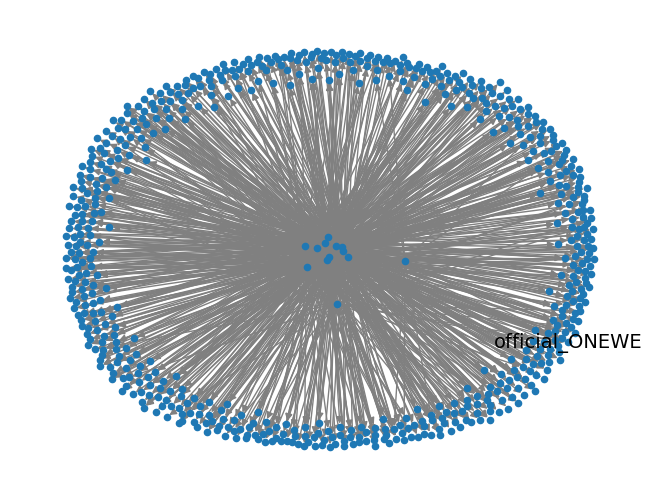

In [66]:
# https://stackoverflow.com/questions/14665767/networkx-specific-nodes-labelings
labels = {}    
hightlight = ['official_ONEWE']
for node in g.nodes():
    if node in hightlight:
        #set the node name as the key and the label as its value 
        labels[node] = node

nx.draw(g, labels=labels, node_size=20, font_size=14, edge_color='gray')

In [112]:
#test

user_id = twitter_with_cache(user_by_url, {'usernames': 'ZingCreamery'})
user_id = user_id['data'][0]['id']
print(user_id)

200
14945857
